# Arabic License Plate Recognition

This notebook goal is to explain our approach for detecting license plates with Arabic letters.
We used classical computer vision for detection of license plates and classical machine learning for recognition of Arabic letters.

The project is divided into three main parts:
1. Plate Extraction
2. Character Segmentation
3. Character Recognition

The dataset used in this project is https://github.com/ahmedramadan96/EALPR

## First: Plate Extraction
Note that the implementation is based on the following research paper: 
[License plate localisation based on morphological operations](https://www.researchgate.net/publication/221144556_License_plate_localisation_based_on_morphological_operations).

In [57]:
import cv2
import numpy as np
from commonfunctions import *
import imutils

Step 1: Apply morphological operations to the image to highlight the license plate region.

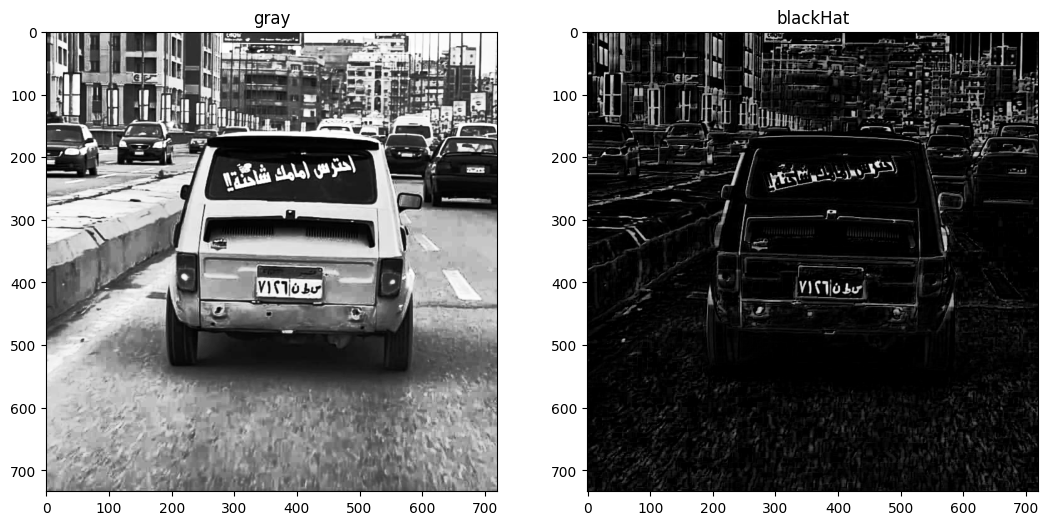

In [58]:
img_path = 'Dataset\\Vehicles\\0001.jpg'
# Load your image
image = cv2.imread(img_path) 

image_copy = image.copy()

# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  

# enhance contrast using histogram equalization
gray = cv2.equalizeHist(gray)

gray_original = gray.copy()

blackHat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, cv2.getStructuringElement(cv2.MORPH_RECT, (10, 4)))

show_images([gray,blackHat], ["gray","blackHat"])

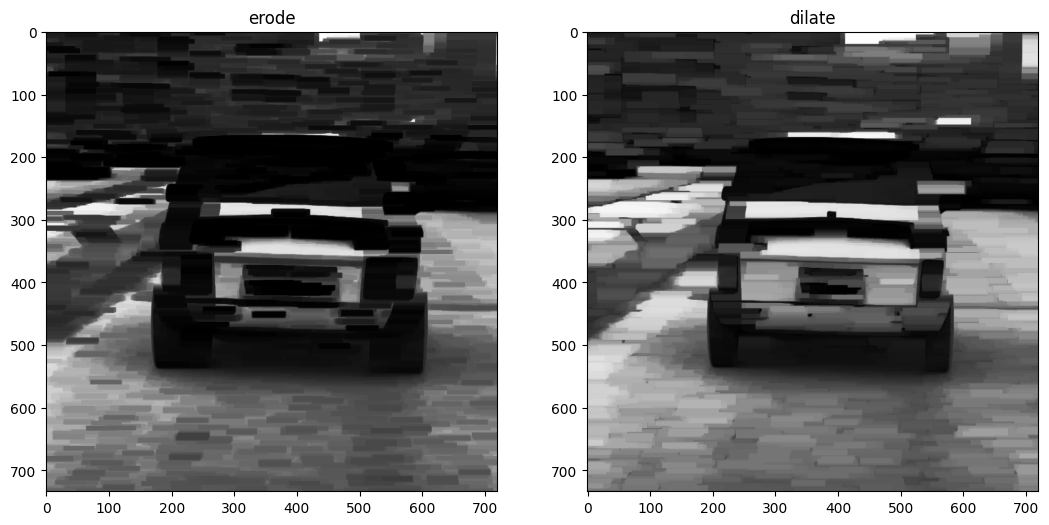

In [59]:
# The following parameters were tuned to get the best results
# Note that they were adjusted based on Egyptian license plates
# Parameters are:
# 1- The morphological kernel size
# 2- Number of iterations of the morphological operations

rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (25, 4))
erode = cv2.erode(gray, rectKernel, iterations=2)
dilate = cv2.dilate(erode, rectKernel, iterations=2)
show_images([erode, dilate], ["erode", "dilate"])

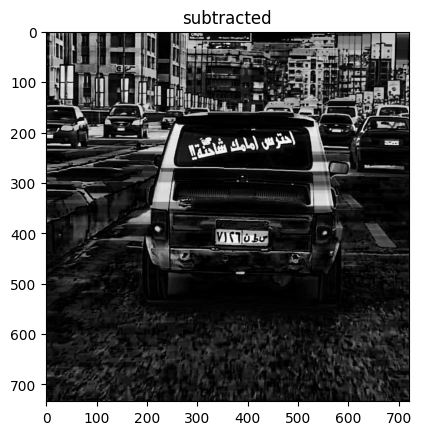

In [60]:
# Subtract the dilated image from the original image as in the paper
# Noting that the license plate area s now highlighted

subtracted = cv2.subtract(gray, dilate)
show_images([subtracted], ["subtracted"])

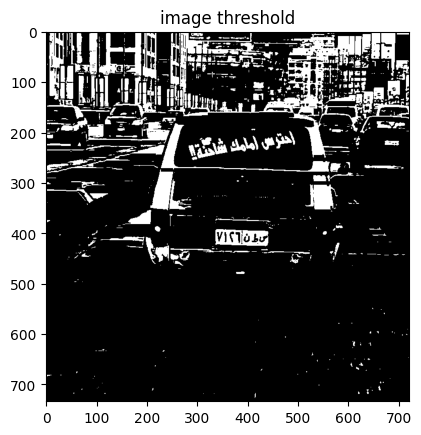

In [61]:
# Dynamically calculate the threshold using Otsu's method

img_threshold = cv2.threshold(subtracted, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
show_images([img_threshold], ["image threshold"])

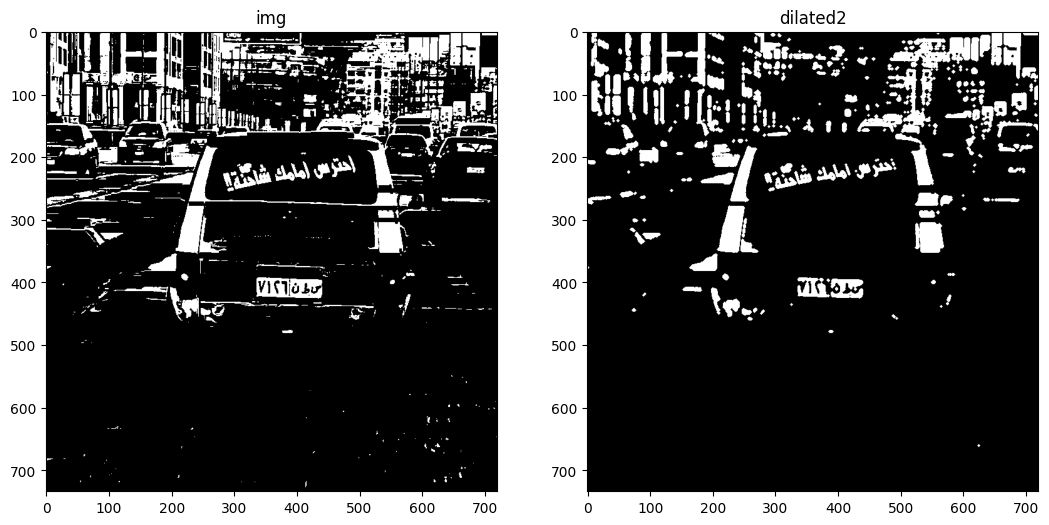

In [62]:
# Diamond kernel for morphological operations 
# Goal is to remove noise and enhance the license plate area
# We define the noise as any information that is not part of the license plate 
# Since the image contains letters where diamond shape is suitable for this task

kernel_data = np.array([[0, 0, 1, 0, 0],
                        [0, 1, 1, 1, 0],
                        [1, 1, 1, 1, 1],
                        [0, 1, 1, 1, 0],
                        [0, 0, 1, 0, 0]], dtype=np.uint8)

eroded2 = cv2.erode(img_threshold, kernel_data, iterations=1)
dilated2 = cv2.dilate(eroded2, kernel_data, iterations=1)

show_images([img_threshold, dilated2], ["img", "dilated2"])

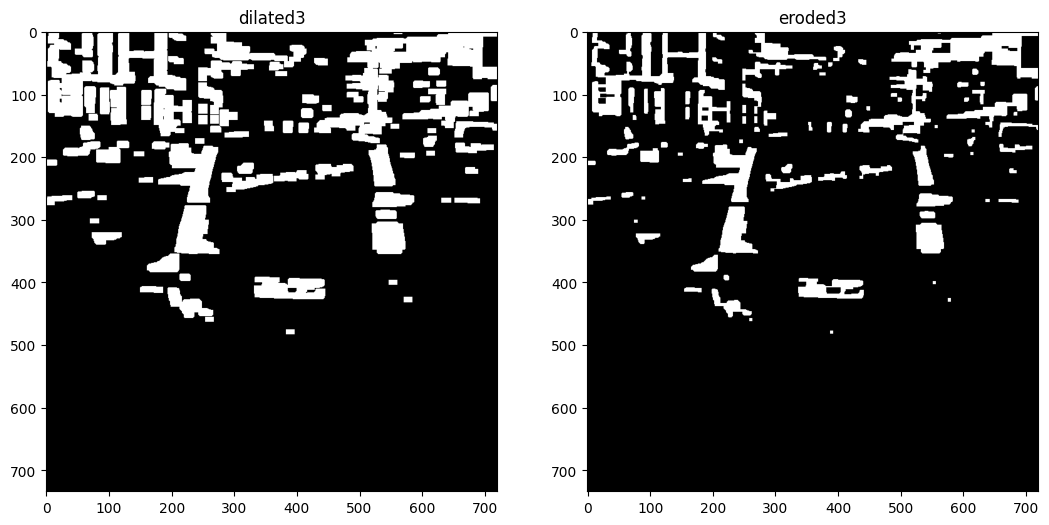

In [63]:
# Use a rectangular kernel to only keep the license plate area as much as possible

kern2 = cv2.getStructuringElement(cv2.MORPH_RECT, (10, 4))

eroded6 = cv2.erode(dilated2, None, iterations=2)
dilated6 = cv2.dilate(eroded6, None, iterations=2)

dilated3 = cv2.dilate(dilated6, kern2, iterations=1)
eroded3 = cv2.erode(dilated3, kern2, iterations=1)

show_images([dilated3, eroded3], ["dilated3", "eroded3"])

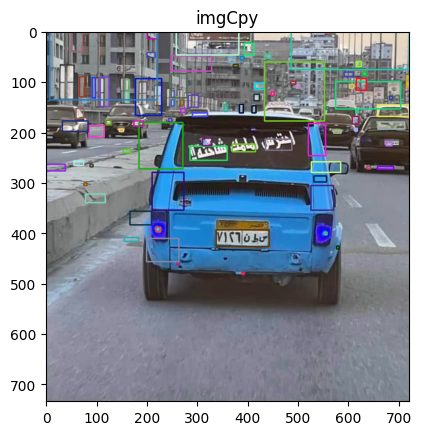

In [64]:
# Show all possible contours

cnts = cv2.findContours(eroded3.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

imgCpy = image.copy()

for c in cnts:
    (x, y, w, h) = cv2.boundingRect(c)
    rand_color = np.random.randint(0, 255, size=3).tolist()
    cv2.rectangle(imgCpy, (x, y), (x + w, y + h), rand_color, 2)

show_images([imgCpy], ["imgCpy"])

Till this point we have detected all possible plates in the image after doing some morphological operations. The next step is to extract the plate from the image.

Step 2: Extract the plate from the image using contours and applying specific criteria based on:
1. The area of the contour
2. The aspect ratio of the contour
3. The number of characters in the contour

In [65]:
# Count the number of characters in an image using contours
def get_number_of_chars_in_plate(rectangle):
        x, y, w, h = rectangle

        rect_blackHat = blackHat[y:y+h, x:x+w]
        rect_blackHat = cv2.threshold(
            rect_blackHat, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

        contours = cv2.findContours(rect_blackHat.copy(),
                                    cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        contours = imutils.grab_contours(contours)

        contours_filtered = []
        filtered_rectangles = []
        candidate_letters_cnt = 0

        center = h/2 + (h/2)*0.2

        for c in contours:
            (x, y, w, h) = cv2.boundingRect(c)
            area = w*h
            # delete very small or very large rectangle.
            if area > 50 and area < 1000:
                # keep thin rectangles and rectangles near the center
                if h/w >= 1 and y <= center <= y+h:
                    candidate_letters_cnt += 1
                filtered_rectangles.append((x, y, w, h))

        imgCpy = rect_blackHat.copy()
        for c in filtered_rectangles:
            (x, y, w, h) = c
            rand_color = np.random.randint(0, 255, size=3).tolist()
            cv2.rectangle(imgCpy, (x, y), (x + w, y + h), rand_color, 2)
        show_images([imgCpy], ["Rectangle candidate showing its characters"])
        return candidate_letters_cnt

In [66]:
# Get the bounding box of the license plate candidates
# With specific aspect ratio, area and number of characters

def get_all_candidate_rectangles(image):
        connectedComponents = cv2.connectedComponentsWithStats(
            image, 4, cv2.CV_32S)

        (numLabels, labels, stats, centroids) = connectedComponents

        output = image_copy.copy()

        plates = []

        for i in range(0, numLabels):
            x = stats[i, cv2.CC_STAT_LEFT]
            y = stats[i, cv2.CC_STAT_TOP]
            w = stats[i, cv2.CC_STAT_WIDTH]
            h = stats[i, cv2.CC_STAT_HEIGHT]
            area = stats[i, cv2.CC_STAT_AREA]
            (cX, cY) = centroids[i]
            aspectRatio = w / h

            if aspectRatio > 1.70 and aspectRatio < 6 and area > 1200:
                chars_cnt = get_number_of_chars_in_plate((x, y, w, h))
                cost = chars_cnt/w
                plates.append((cost, (x, y, w, h)))

                cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 3)
                cv2.circle(output, (int(cX), int(cY)), 4, (0, 0, 255), -1)
        
        show_images([output], ["Candidate Plates"])
        return plates

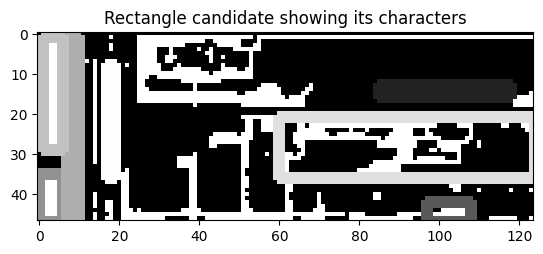

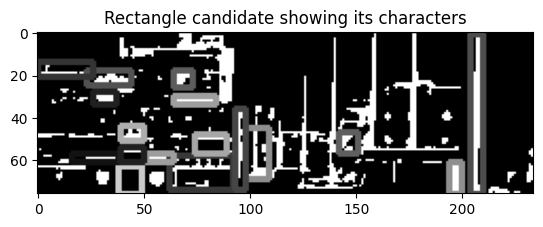

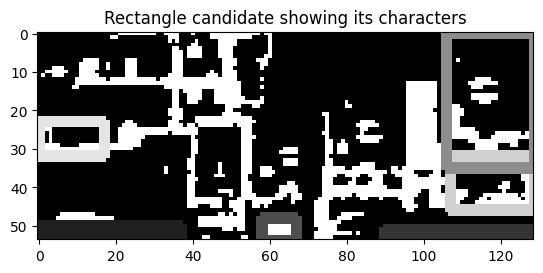

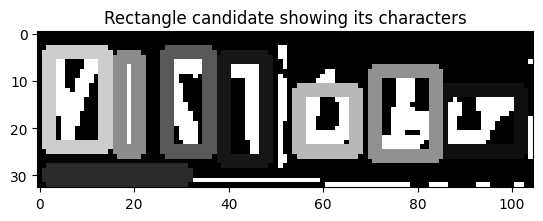

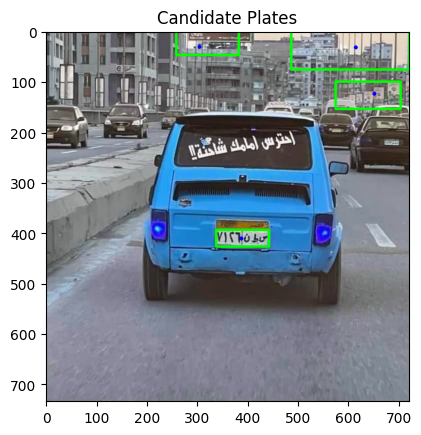

In [67]:
# Get the best candidate plate
# Based on:
# 1- Number of characters
# 2- Aspect ratio of the plate
# 3- Area of the plate

rectangles = get_all_candidate_rectangles(eroded3)

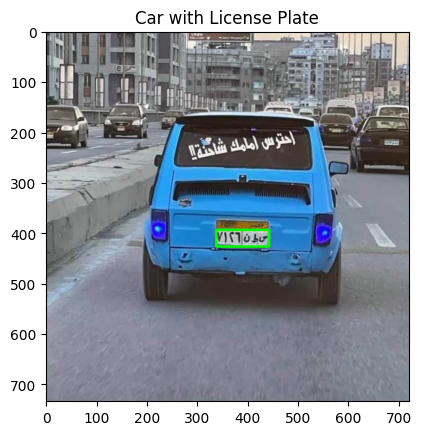

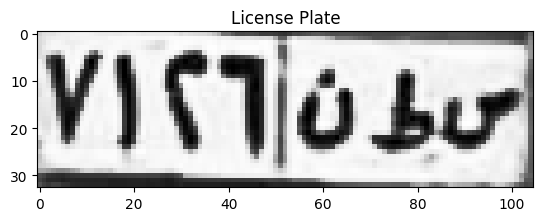

In [68]:
# Sort to get the region with most characters

sorted_rectangles = sorted(rectangles, key=lambda x: -x[0])
_,license_plate_coordinates = sorted_rectangles[0]

x, y, w, h = license_plate_coordinates
license_plate_region = image_copy.copy()
cv2.rectangle(license_plate_region, (x, y), (x + w, y + h), (0, 255, 0), 3)
show_images([license_plate_region], ["Car with License Plate"])

# Crop the license plate region
license_plate = gray_original[y:y+h, x:x+w]
license_plate_colored = image_copy[y:y+h, x:x+w]
show_images([license_plate], ["License Plate"])
                

## Second: Character Segmentation

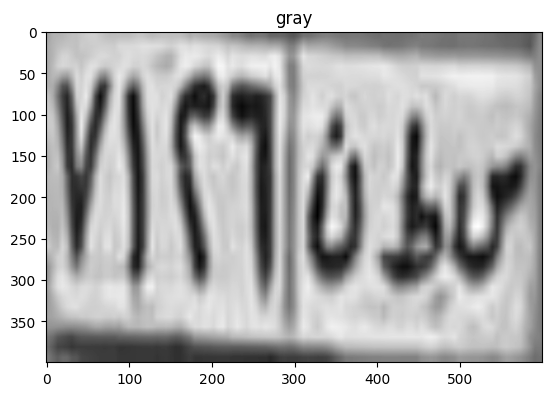

In [69]:
license_plate = cv2.resize(license_plate_colored, (600, 400))
license_plate_gray = cv2.cvtColor(license_plate, cv2.COLOR_BGR2GRAY)
show_images([license_plate_gray], ["gray"])

In [70]:
# unsharp mask to sharpen the edges

def unsharp_mask(image, sigma=1.0, strength=1.5):
    # Apply Gaussian blur
    blurred = cv2.GaussianBlur(image, (0, 0), sigma)
    # Subtract the blurred image from the original
    sharpened = cv2.addWeighted(image, 1.0 + strength, blurred, -strength, 0)
    return sharpened

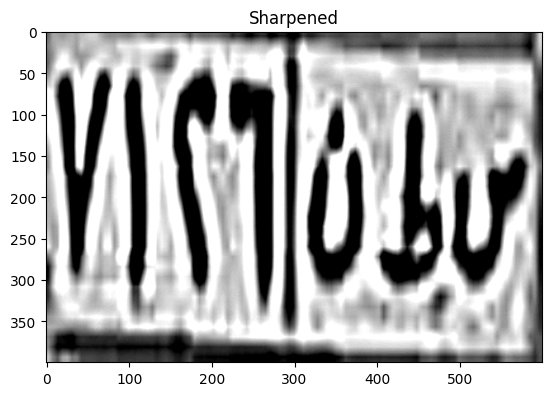

In [71]:
# Apply unsharp mask to strength the edges
sharp_image = unsharp_mask(license_plate_gray, 10, 5)

show_images([sharp_image],["Sharpened"])

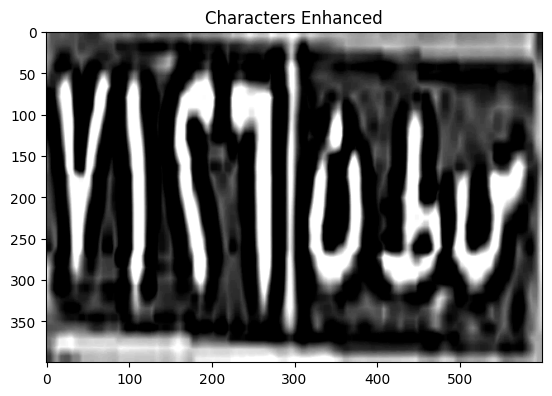

In [72]:
# Remove noise and enhance characters
rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 4))
erode = cv2.erode(sharp_image, (2, 4), iterations=1)
dilate = cv2.dilate(erode, (3, 12), iterations=1)

dilate = cv2.bitwise_not(dilate)
erode = cv2.erode(dilate, None, iterations=2)
show_images([erode],["Characters Enhanced"])

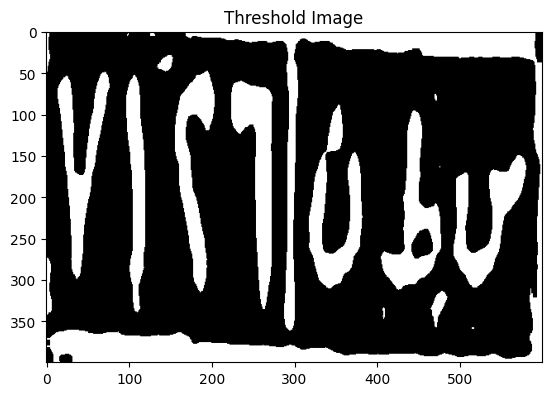

In [73]:
# Apply threshold to get binary image
threshold_image = cv2.threshold(
    erode, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

show_images([threshold_image],["Threshold Image"])

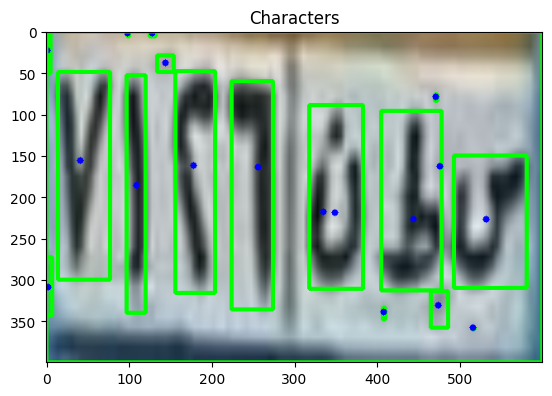

In [74]:
connectedComponents = cv2.connectedComponentsWithStats(
            threshold_image, 8, cv2.CV_32S)

(numLabels, labels, stats, centroids) = connectedComponents
output = license_plate.copy()
rectangles = []
for i in range(1, numLabels):
    x = stats[i, cv2.CC_STAT_LEFT]
    y = stats[i, cv2.CC_STAT_TOP]
    w = stats[i, cv2.CC_STAT_WIDTH]
    h = stats[i, cv2.CC_STAT_HEIGHT]
    area = stats[i, cv2.CC_STAT_AREA]
    (cX, cY) = centroids[i]
    rectangles.append((x, y, w, h))
    cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 4)
    cv2.circle(output, (int(cX), int(cY)), 4, (0, 0, 255), -1)
show_images([output], ["Characters"])

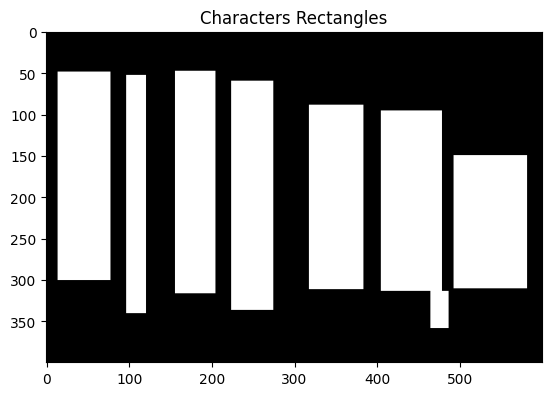

In [75]:
# Mark possible characters with white rectangles

img_filled = np.zeros_like(license_plate)
for rectangle in rectangles:
    x, y, w, h = rectangle
    aspect_ratio = w / h
    area = w * h
    if 0 < aspect_ratio < 1.4 and 500 < area < 50000:
        cv2.rectangle(img_filled, (x, y), (x + w, y + h),
                      (255, 255, 255), thickness=cv2.FILLED)

show_images([img_filled],["Characters Rectangles"])


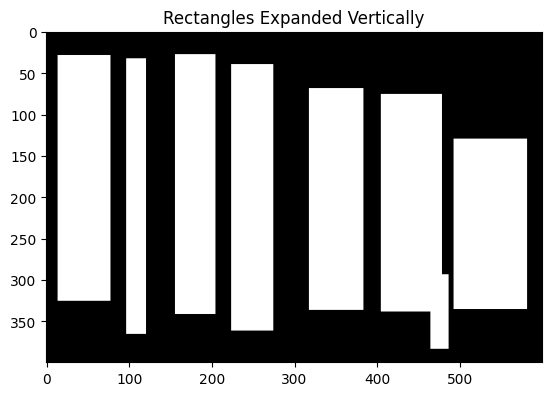

In [76]:
# Erode vertically to merge arabic characters that are separated onto two rectangles
# Goal is to merge triangles vertically
img_filled = cv2.morphologyEx(img_filled, cv2.MORPH_DILATE,
                              cv2.getStructuringElement(cv2.MORPH_RECT, (1, 10)), iterations=5)
img_filled = cv2.cvtColor(img_filled, cv2.COLOR_BGR2GRAY)
show_images([img_filled],["Rectangles Expanded Vertically"])

In [77]:
# Get the contours of the characters
contours = cv2.findContours(
            img_filled, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = imutils.grab_contours(contours)
candidate_rectangles = []
for contour in contours:
    (x, y, w, h) = cv2.boundingRect(contour)
    candidate_rectangles.append((x, y, w, h))

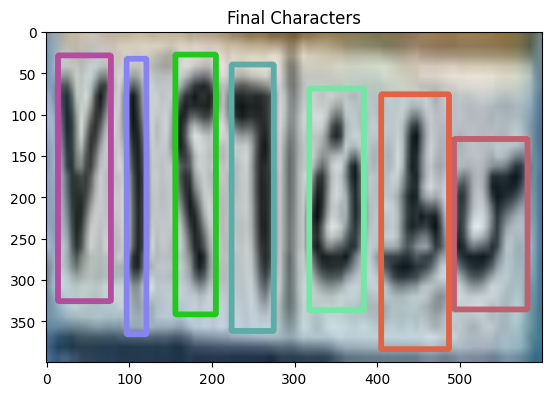

In [78]:
# Get the coordinates of the characters
# Finalize the selection of characters by removing small rectangles

img_copy = license_plate.copy()
image_area = img_copy.shape[0] * img_copy.shape[1]
img_width = img_copy.shape[1]
final_rectangles = []
for r in candidate_rectangles:
    if r is not None:
        (x, y, w, h) = r
        aspect_ratio = w / h
        area = w * h
        if w < 0.6 * h and 1500 < area < image_area / 5 and img_width / 50 < w:
            final_rectangles.append(r)
            color = np.random.randint(0, 255, size=(3,)).tolist()
            cv2.rectangle(img_copy, (x, y), (x + w, y + h), color, 5)
            
show_images([img_copy],["Final Characters"])

## Third: Character Recognition

We will train a knn classifier on the dataset provided to recognize the Arabic letters.

In [79]:
import os
from sklearn import neighbors
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from skimage import feature

# joblib is used to save the model
import joblib

In [80]:
def train_knn_model(data_set_path):
    # read images
    x_train = []
    y_train = []
    for dir in os.listdir(data_set_path):
        
        #label is directory name
        label = dir
        for file in os.listdir(os.path.join(data_set_path,dir)):
            if file.endswith('.png'):
                char_path = os.path.join(data_set_path,dir,file)
                # check if file exists
                if not os.path.isfile(char_path):
                    continue
                try:
                    img = io.imread(char_path)
                except:
                    continue
                if len(img.shape) == 3:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                img = cv2.resize(img, (20, 50))
                
                # extract hog features
                hog_img = feature.hog(img, orientations=9, pixels_per_cell=(8, 8),
                                      cells_per_block=(2, 2), transform_sqrt=True, block_norm="L2-Hys")
                # hog_img = img.flatten()/255
                x_train.append(hog_img)
                y_train.append(label)
       
    data_set = np.array(x_train)
    labels = np.array(y_train)
    
    # split data
    X_train, X_test, y_train, y_test = train_test_split(data_set, labels, test_size=0.2, random_state=1)
    
    # train model
    model = neighbors.KNeighborsClassifier(n_neighbors=3)
    model.fit(X_train, y_train)
    
    # test model
    y_pred = model.predict(X_test)
    print(classification_report(y_test,y_pred))
    
    
    return model
    

In [81]:
# model = train_knn_model('Chars_DataSet')
# joblib.dump(model, 'model_knn.pkl')

In [82]:
# compute the standard deviation of characters in the dataset to be used as a threshold
# to eliminate non characters from being classified

# model_threshold = compute_threshold('Chars_DataSet',model)
# The result was 1.5

model_threshold = 1.5

In [83]:
knn_model = joblib.load('model_knn.pkl')

['س']
['ط']
['ن']
['٦']
['٢']
['٧']


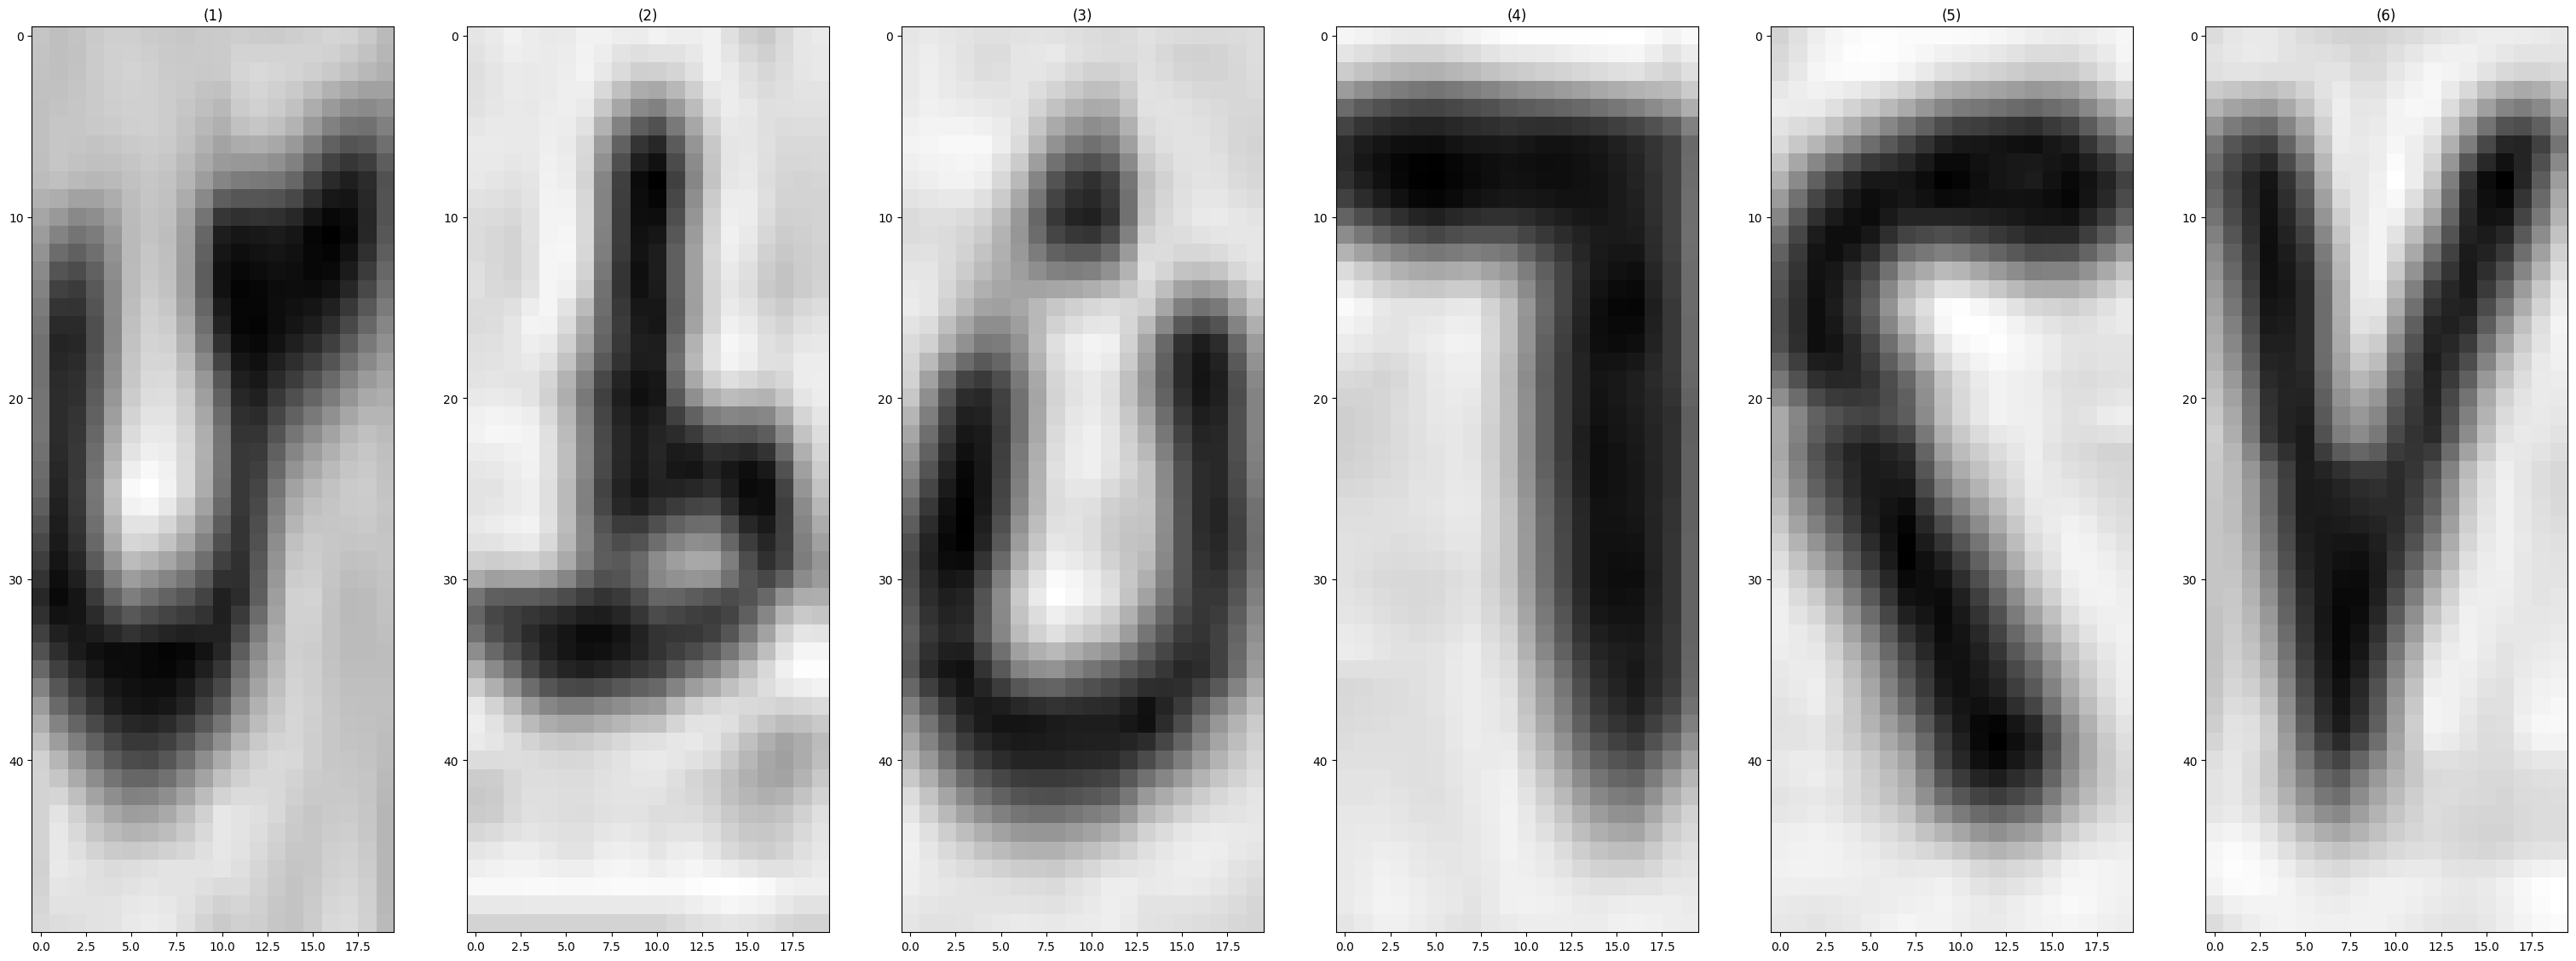

سطن٦٢٧


In [84]:
final_rectangles = sorted(final_rectangles, key=lambda x: -x[0])
license_plate = ''
characters = []
for rectangle in final_rectangles:
    x, y, w, h = rectangle
    
    char_img = license_plate_gray[y:y+h, x:x+w]
    char_img = cv2.resize(char_img, (20, 50))
    
    hog_img = feature.hog(char_img, orientations=9, pixels_per_cell=(8, 8),
                          cells_per_block=(2, 2), transform_sqrt=True, block_norm="L2-Hys")

    char = knn_model.predict([hog_img])
    
    distances, _ = knn_model.kneighbors([hog_img])
    nearest_character = distances[0][0]
    
    if nearest_character > model_threshold:
        continue
    
    print(char)
    license_plate += char[0]
    characters.append(char_img.copy())
    
show_images(characters)
print(license_plate)